In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from google.colab import files

In [2]:
# Adım 1: Veri setini yükleme
uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])


Saving Steel_industry_data.csv to Steel_industry_data.csv


In [3]:
# Adım 2: Tarih-saat sütununu datetime formatına çevirme ve sıralama
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
df = df.sort_values('date')


In [4]:

# Adım 3: Zamanla ilgili ek özellikler çıkarma
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35040 entries, 95 to 35038
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  35040 non-null  datetime64[ns]
 1   Usage_kWh                             35040 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64       
 4   CO2(tCO2)                             35040 non-null  float64       
 5   Lagging_Current_Power_Factor          35040 non-null  float64       
 6   Leading_Current_Power_Factor          35040 non-null  float64       
 7   NSM                                   35040 non-null  int64         
 8   WeekStatus                            35040 non-null  object        
 9   Day_of_week                           35040 non-null  object        
 10  Lo

In [6]:
# Adım 4: Geçmiş tüketim verisi ekleme (son 24 saatin ortalaması)
sequence_length = 96  # 24 saat (15 dakikada 1 ölçüm, 24*4=96)
df['past_24h_mean'] = df['Usage_kWh'].rolling(window=sequence_length, min_periods=1).mean().shift(1)



In [7]:
# Adım 5: Peak noktalarını tespit etme ve is_peak sütunu ekleme
df['is_peak'] = (df['Usage_kWh'] >= 75).astype(int)



In [8]:
# Adım 6: Kategorik değişkenleri olduğu gibi bırakma (XGBoost'un kategorik desteği kullanılacak)
df['Load_Type'] = df['Load_Type'].astype('category')
df['WeekStatus'] = df['WeekStatus'].astype('category')
df['Day_of_week'] = df['Day_of_week'].astype('category')


In [9]:
df.head()


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,hour,day,month,year,past_24h_mean,is_peak
95,2018-01-01 00:00:00,3.42,3.46,0.0,0.0,70.30,100.0,0,Weekday,Monday,Light_Load,0,0,1,2018,NaN,0
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load,0,0,1,2018,3.4200,0
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load,0,0,1,2018,3.2950,0
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load,0,0,1,2018,3.5300,0
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load,1,0,1,2018,3.4575,0


In [10]:
# Adım 7: Özellikleri ve hedef değişkeni belirleme
features = ['hour', 'day', 'month', 'year', 'NSM', 'past_24h_mean', 'is_peak', 'Load_Type', 'WeekStatus', 'Day_of_week']
X = df[features]
y = df['Usage_kWh']


In [11]:
# Adım 8: Veriyi zaman sırasına göre ayırma (ilk %80 eğitim, son %20 test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [12]:

# Adım 9: XGBoost modelini oluşturma ve eğitme (kategorik desteği etkinleştirme)
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42, enable_categorical=True)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [13]:

# Adım 10: Tahmin yapma
y_pred = xgb_model.predict(X_test)

# Adım 11: Model değerlendirme (MSE ve R² skoru)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Skoru: {r2:.4f}")

Mean Squared Error: 173.28691550691195
R² Skoru: 0.8239


In [14]:

# Adım 11: Saatlik tahminler için veriyi gruplama
hourly_df = df.iloc[train_size:].groupby([df['date'].dt.date[train_size:], df['hour'][train_size:]])['Usage_kWh'].mean().reset_index()
hourly_actual = hourly_df.tail(24)['Usage_kWh'].values

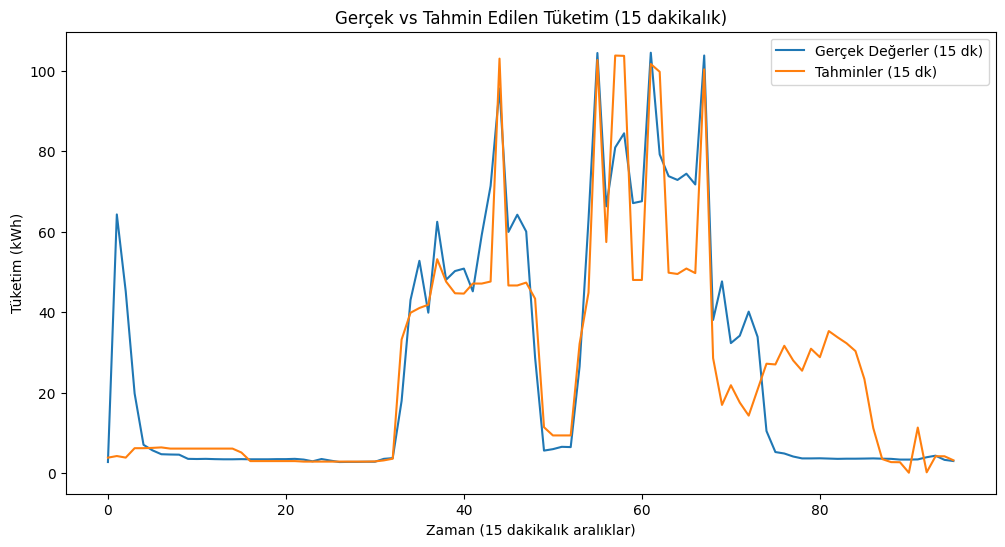

In [15]:

# Adım 12: Görselleştirme - 15 dakikalık tahmin grafiği
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:96], label='Gerçek Değerler (15 dk)')
plt.plot(y_pred[:96], label='Tahminler (15 dk)')
plt.xlabel('Zaman (15 dakikalık aralıklar)')
plt.ylabel('Tüketim (kWh)')
plt.title('Gerçek vs Tahmin Edilen Tüketim (15 dakikalık)')
plt.legend()
plt.show()

In [16]:

# Adım 13: Saatlik tahminler için veriyi gruplama
hourly_df = df.iloc[train_size:].groupby([df['date'].dt.date[train_size:], df['hour'][train_size:]])['Usage_kWh'].mean().reset_index()
hourly_actual = hourly_df.tail(24)['Usage_kWh'].values

# Adım 14: Saatlik tahminler
hourly_pred = df.iloc[train_size:].groupby([df['date'].dt.date[train_size:], df['hour'][train_size:]])['Usage_kWh'].mean().reset_index()
hourly_pred['Predicted'] = y_pred[-len(hourly_pred):]
hourly_pred = hourly_pred.tail(24)['Predicted'].values

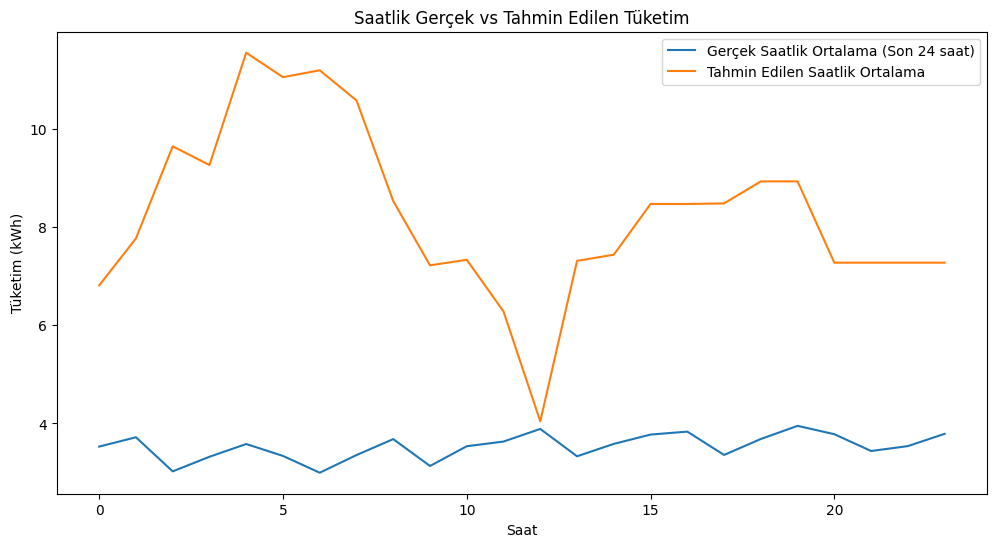

In [17]:
# Adım 15: Görselleştirme - Saatlik tahmin grafiği
plt.figure(figsize=(12, 6))
plt.plot(range(24), hourly_actual, label='Gerçek Saatlik Ortalama (Son 24 saat)')
plt.plot(range(24), hourly_pred, label='Tahmin Edilen Saatlik Ortalama')
plt.xlabel('Saat')
plt.ylabel('Tüketim (kWh)')
plt.title('Saatlik Gerçek vs Tahmin Edilen Tüketim')
plt.legend()
plt.show()